In [1]:

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle
from torchvision import datasets
from torchvision import transforms
from google.colab import drive
from torch.utils.data.sampler import SubsetRandomSampler

drive.mount('/Plastic_dataset')

Mounted at /Plastic_dataset


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
labels = set()
for img in os.listdir('/Plastic_dataset/MyDrive/Plastic_dataset')[:]:
  labels.add(img.split('_')[2])
  #print(img)
for img in os.listdir('/Plastic_dataset/MyDrive/Positive'):
  labels.add(img.split('_')[2])
labels = list(labels)

In [4]:
labels = ['LDPE4',
 'PS06',
 'HDPE',
 'PVC03',
 'PEHD02',
 'PP05',
 'OTHER07',
 'PELD04',
 'pp05',
 'cpap81',
 'CPAP',
 'FE40',
 'PAP20',
 '7OTHER',
 'HDPE02',
 'ALU41',
 'PEP05',
 'GL71',
 'hdpe',
 'HDPE2',
 'hdpe2',
 'Pp05',
 'PAP21',
 'PET01',
 'GL70',
 'PAP22',
 'LDPE04']

In [ ]:
dataset_x = []
dataset_y = []
DATA = []
path = '/Plastic_dataset/MyDrive/Plastic_dataset'
for img in os.listdir(path):
    img_array = cv2.resize(cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE), (64, 64))
    #dataset_x.append(img_array)
    #dataset_y.append(labels.index(img.split('_')[2]))
    DATA.append([img_array, labels.index(img.split('_')[2])])
path = '/Plastic_dataset/MyDrive/Positive'
for img in os.listdir(path):
    img_array = cv2.resize(cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE), (64, 64))
    #dataset_x.append(img_array)
    #dataset_y.append(labels.index(img.split('_')[2]))
    DATA.append([img_array, labels.index(img.split('_')[2])])

In [ ]:
random.shuffle(DATA)
for x, y in DATA:
  dataset_x.append(x)
  dataset_y.append(y)


In [ ]:
X_train =torch.tensor(np.array(dataset_x[:int(len(dataset_x)*0.8)]), dtype = torch.float).unsqueeze(-3)/255
y_train =torch.tensor(np.array(dataset_y[:int(len(dataset_y)*0.8)]))
X_test = torch.tensor(np.array(dataset_x[int(len(dataset_x)*0.8):]), dtype = torch.float).unsqueeze(-3)/255
y_test = torch.tensor(np.array(dataset_y[int(len(dataset_y)*0.8):]))

In [ ]:

pickle_test_out = open("/Plastic_dataset/MyDrive/X_test.pickle", "wb")
pickle.dump(X_test, pickle_test_out)
pickle_test_out.close()

pickle_out = open("/Plastic_dataset/MyDrive/X_train.pickle", "wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("/Plastic_dataset/MyDrive/y_train.pickle", "wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open("/Plastic_dataset/MyDrive/y_test.pickle", "wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [5]:
pickle_in = open("/Plastic_dataset/MyDrive/X_test.pickle", "rb")
X_test = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/Plastic_dataset/MyDrive/X_train.pickle", "rb")
X_train = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/Plastic_dataset/MyDrive/y_test.pickle", "rb")
y_test = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/Plastic_dataset/MyDrive/y_train.pickle", "rb")
y_train = pickle.load(pickle_in)
pickle_in.close()

In [6]:
X_train.shape

torch.Size([7297, 1, 64, 64])

In [7]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=1, out_channels=3, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(2704, 240)
        self.act3 = activation_function

        self.fc2 = torch.nn.Linear(240, 120)
        self.act4 = activation_function

        self.fc3 = torch.nn.Linear(120, 84)
        self.act5 = activation_function

        self.fc4 = torch.nn.Linear(84, 27)

        self.dropout = nn.Dropout(0.25)

    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        x = self.act5(x)
        x = self.dropout(x)
        x = self.fc4(x)
        
        
        return x

lenet5 = LeNet5().double()
lenet5

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (act1): Tanh()
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=2704, out_features=240, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (act5): Tanh()
  (fc4): Linear(in_features=84, out_features=27, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [27]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=3.0e-4)

In [38]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(60):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
        if epoch % 10 == 0:
          print(accuracy)
    #del net
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}


model = LeNet5(activation='relu', conv_size=3, pooling='avg', use_batch_norm=True)
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(model, X_train, y_train, X_test, y_test)

tensor(0.5129)
tensor(0.8888)
tensor(0.9008)
tensor(0.8937)
tensor(0.9014)
tensor(0.9030)


In [39]:
torch.save(model.state_dict(), '/Plastic_dataset/MyDrive/model.pth')

In [8]:
trained_model = LeNet5(activation='relu', conv_size=3, pooling='avg', use_batch_norm=True)
trained_model.load_state_dict(torch.load('/Plastic_dataset/MyDrive/model.pth'), strict = False)
test_preds = trained_model.forward(X_test)
accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()

In [10]:
accuracy

tensor(0.9074)

In [11]:
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 80.2 MB/s eta 0:00:00


In [12]:
!pip install onnx_tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 21.6 MB/s eta 0:00:00


In [13]:
 import onnx
 from onnx_tf.backend import prepare

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [14]:
dummy_input = torch.randn(1, 1, 64, 64)
torch.onnx.export(trained_model, dummy_input, '/Plastic_dataset/MyDrive/model.onnx')

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [19]:
onnx_model = onnx.load('/Plastic_dataset/MyDrive/model.onnx')

onnx.onnx_ml_pb2.ModelProto

In [21]:
tf_rep = prepare(onnx_model)

onnx_tf.backend_rep.TensorflowRep

In [23]:
import tensorflow as tf

tf_rep.export_graph("/Plastic_dataset/MyDrive/model.pb")

converter = tf.lite.TFLiteConverter.from_frozen_graph(
        "/Plastic_dataset/MyDrive/model.pb", tf_rep.inputs, tf_rep.outputs)
tflite_model = converter.convert()
open("/Plastic_dataset/MyDrive/model.tflite", "wb").write(tflite_model)

KeyError: ignored

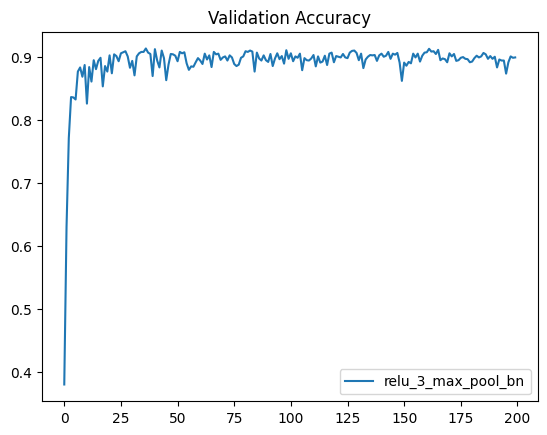

In [ ]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

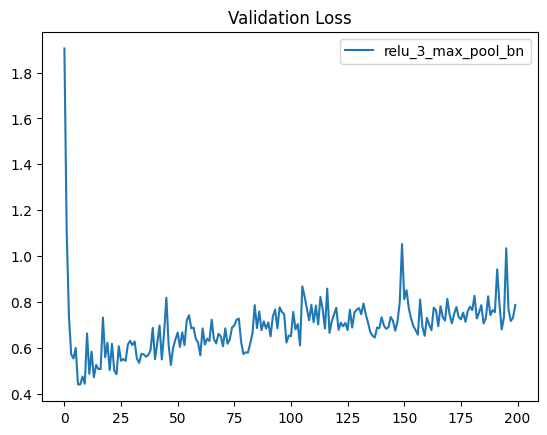

In [ ]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');